# Stack Overflow Network Analysis
Claas Brüß, Simon Romanski and Maximilian Rünz

#### NOTE: Originally we claimed that the data visualization used in this project will be credited for the Data Visualization course. As we finally chose a very different approach in Data Visualization, this claim does not hold anymore. Apart from using the same data set, these are two clearly seperated projects.

## 1 Introduction

There are comprehensive studies on how groups form and work together in a face-to-face team work scenario. However, even though the development of the internet has allowed open platforms for collaboration in a massive scale, less research has been conducted on patterns of collaboration in that domain.

This project analyzes the stackoverflow community representing it as a graph. We are applying network analysis methods to subcommunities for libraries like Numpy in order to understand the structure of the community. 

In a next stage we are comparing the communities to theoretical network models as well as to real network models to obtain insights about work patterns in the community. Finally we will compare those insights with proven psychological models of group work theorey to gain intuition about knowledge transfer and work in these communites. We will show that the shape of group work and knowledge transfer changes by the means of online communities.

In [1]:
%matplotlib inline

import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

# Own modules
import DataProcessing as proc
import DataCleaning as clean
import NetworkAnalysis as analysis
import Classification as classification
import NetworkEvolution as evol

## 2 Data processing

The data behind this project was provided by Stack Overflow itself. They release frequent data dumps on [archive.org](https://archive.org/details/stackexchange). We have analyzed all posts from [Stack Overflow](https://stackoverflow.com/) with the `stackoverflow.com-Posts.7z` file. The compressed file contains a list of all questions and answeres formatted as xml.

**Note: As the analyzed xml file is more than 50 GB big, the data processing takes several hours. The data processing part can be skipped, the uploaded zip contains the constructed edge lists.**

In [2]:
# Paths that will be used
posts_path = os.path.join("Posts.xml")
questions_path = os.path.join("Questions.json")
answers_path = os.path.join("Answers.json")
edge_list_path = os.path.join("Edges.json")
edge_list_tag_path = os.path.join("Tags")

### 2.1 Extract meaningful features

Before we started our analysis we extracted the features of the posts which are interesting for us. The provided features can be looked up in [this](https://ia800801.us.archive.org/23/items/stackexchange/readme.txt) text file. We selected the following features for our analysis:
* PostTypeId (Question/Answer)
* Id
* ParentId
* AcceptedAnswerId
* CreationDate
* Score
* OwnerUserId
* Tags

Based on the `PostType` the posts are then stored then stored in the questions or answers JSON file.

In [ ]:
%%time
# Create JSON for questions and answers
proc.split_qa_json_all(questions_path, answers_path, posts_path)

### 2.2 Create edge list

Having selected the meaningful features, we started to create the graph. Each answer is matched with its corresponding question. The result are two nodes and one edge: The nodes represent Stack Overflow users. The edge connectes those users from the inquirer to the respondent.

In [ ]:
%%time
# create edge list
proc.create_edge_list_all(questions_path, answers_path, edge_list_path)

### 2.3 Split networks by tags

After we tried to analyze the whole Stack Overflow network and came to the conclusion, that it is simpy too big, we decided to split the network by tags. Therefore we created one edge list per Tag (e.g numpy).

In [ ]:
%%time
# split in file for each tag
proc.split_edge_list_tags(edge_list_tag_path, edge_list_path)

### 2.4 Order edges by time

In order to simplify the analysis of the network evolution, we ordered the edges based on the creation date of the answer.

In [ ]:
%%time
# order by time
proc.order_edge_lists_tags_time(edge_list_tag_path)

### 2.5 Format edge list to txt files

Last but not least, the json files are converted into txt edge list, so that they can be read easily by networkx.

In [ ]:
%%time
proc.edge_lists_to_txt(edge_list_tag_path)

## 3 Data Cleaning

During the network analysis we noticed that it makes sense to clean the created network. Therefore, we implemented several filters:
* Filter by attribute
* Filter by degree
* Filter by component
* Remove self loops

The most frequently used filter is the filter for attributes. Using this filter we remove questions and answers with negative votes, as they are not helpful for the community.
Furthermore this filter will be used to analyse the evolution of the network.

In [2]:
network_path = os.path.join("Tags", "numpy_complete_ordered_list.txt")
network = nx.read_edgelist(network_path,nodetype=int, data=(('time',int),('votes_q', int),('votes_a', int),('accepted', bool)))
network_directed = nx.read_edgelist(network_path, create_using=nx.DiGraph(), nodetype=int, data=(('time',int),('votes_q', int),('votes_a', int),('accepted', bool)))

The whole stackoverflow community has more than 8 million users, 15 million questions and 23 million answers on different aspects of different libraries, programming languages and operating systems.

Hence, we decided to focus on specific widely-used libraries for our investigation. In our case we perform data analysis for a commonly used python library Numpy and compare it to another python library Matlplotlib as well as to a heavily used library for C++ called Eigen. Ultimately we will compare the entire Python community with the Numpy community.

For numpy we then create two networks: one directed and one undirected for different analysis purposes.

In [3]:
# in epoche
min_time = -1
max_time = -1

min_q_votes = 0
max_q_votes = -1
min_a_votes = 0
max_a_votes = -1
accepted = -1

min_degree = -1
max_degree = -1

only_gc = False

no_self_loops = True

### Filter by attributes

In [4]:
network_cleaned = clean.filter_network_attributes(network, min_time, max_time,\
                min_q_votes, max_q_votes, min_a_votes, max_a_votes, accepted)
network_direted_cleaned = clean.filter_network_attributes(network_directed, min_time, max_time,\
                min_q_votes, max_q_votes, min_a_votes, max_a_votes, accepted, directed=True)

### Filter by node degree

In [5]:
network_cleaned = clean.filter_network_node_degree(network_cleaned, min_degree, max_degree)
network_direted_cleaned = clean.filter_network_node_degree(network_direted_cleaned, min_degree, max_degree)

### Only use giant component

In [6]:
if only_gc:
    network_cleaned = clean.filter_network_gc(network_cleaned)
    network_direted_cleaned = clean.filter_network_gc(network_direted_cleaned)

### Remove self loops

In [7]:
if no_self_loops:
    network_cleaned = clean.filter_selfloops(network_cleaned)
    network_direted_cleaned = clean.filter_selfloops(network_direted_cleaned)

## 3 Data Exploration: Network properties

We are starting with some basic properties of the subcommunity. Each node in our graph represents one user.


In [8]:
analysis.get_number_nodes(network_cleaned)

20880

We can see that we have roughly 20.000 users.

In [9]:
analysis.get_number_edges(network_cleaned)

37231

And we have roughly 37.231 edges corresponding to one answer each. 

In [10]:
analysis.get_number_connected_components(network_cleaned)

999

The number of connected components describes the amount of completely seperated groups in the community that do not interfere with each other. A deeper analysis shows that there is in fact one big group and many very small groups.

In [11]:
analysis.get_size_giant_component(network_cleaned)

18934

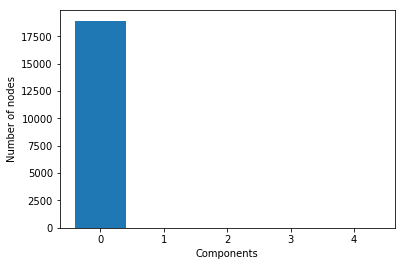

In [12]:
analysis.plot_ranking_component_size(network_cleaned)

In [13]:
analysis.get_number_self_loops(network_cleaned)

0

The self-loops represent answers that users have given to their own questions. As this seems to be counterintuitive, we have removed those in our data cleaning.

In [14]:
analysis.get_avg_degree(network_cleaned)

3.5661877394636017

The average degree for the numpy network is 3.5, we will evaluate this in the exploitation part of this report.

In [15]:
analysis.get_cluster_coefficient(network_cleaned)

0.019708523117604532

The cluster coefficient is relatively low due to the model of our network. More details on that are also following in the data exploitation chapter.

In [16]:
analysis.get_max_degree(network_cleaned)

1384

The maximal degree of a node is tremendously higher than the average degree. This is a little suspicous. Therefore, we will have a look at the distribution of the node degrees.

### Degree distribution

To get insights about the user behaviour, i.e., how many question do users ask and answer we war plotting a degree distribution in the following:

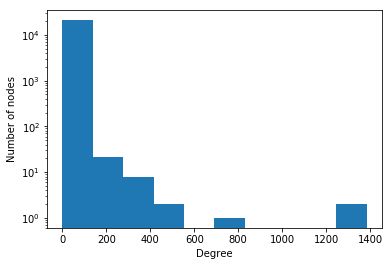

In [17]:
analysis.plot_degree_hist(network_cleaned)

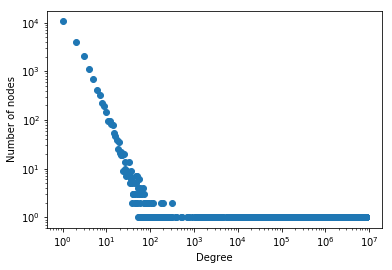

In [18]:
analysis.plot_degree_scatter(network_cleaned)

These plots show a distribution that demonstrates a high number of highly connected nodes. This superlineaer distribution plot imply a hub-and-spoke topology of this network. Note the double-logarithmic scaling of the scatter plot. 

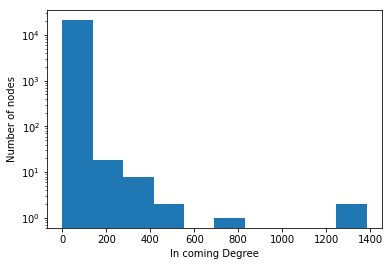

In [19]:
analysis.plot_in_degree_hist(network_direted_cleaned)

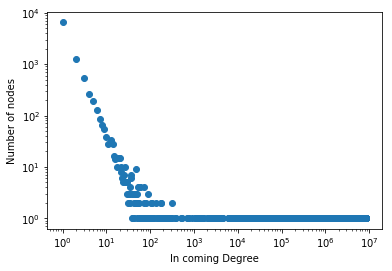

In [20]:
analysis.plot_in_degree_scatter(network_direted_cleaned)

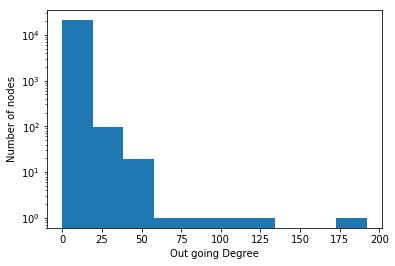

In [21]:
analysis.plot_out_degree_hist(network_direted_cleaned)

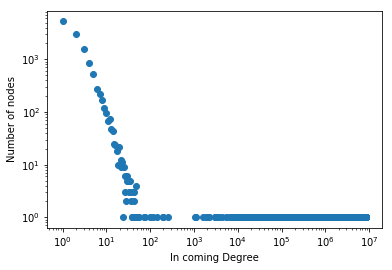

In [22]:
analysis.plot_out_degree_scatter(network_direted_cleaned)

Like before can observe that incoming and outgoing degree distributions both demonstrate bevaior associated with networks with hub-and-spoke topology. The outgoing distribution exhibits this even stronger than the incoming distribution indicating that certain members of the community carry an overpropotional workload in answering questions posed on the platform.

### Attribute Distribution

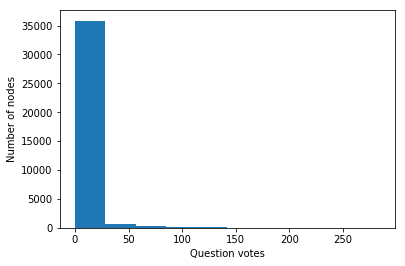

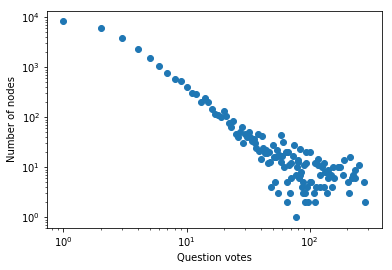

In [23]:
analysis.analyze_attribute_q_votes(network_cleaned)

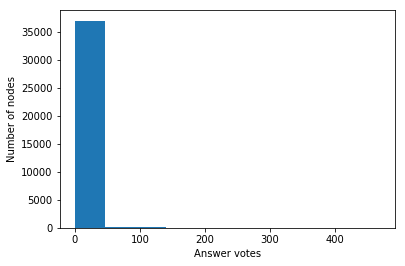

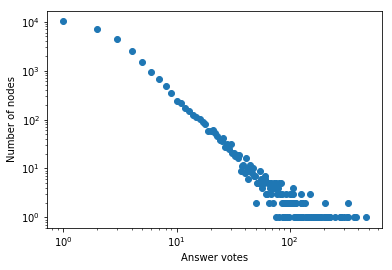

In [24]:
analysis.analyze_attribute_a_votes(network_cleaned)

Another interesting property is the votes per edge as their distribution is another valuable metric to understand how user activity is concentrated on certain areas.

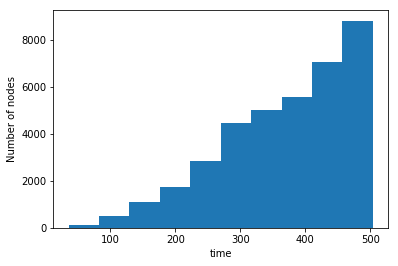

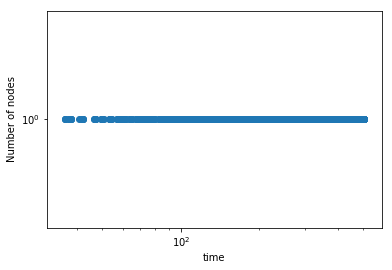

In [25]:
analysis.analyze_attribute_time(network_cleaned)

In general it is interesting to see the evoulution of a network over time. We can see that in this case the amount of edges is conitnuously increasing.

### Comparison

It is instructive to compare the characteristics of the different subcommunities:

In [26]:
for file in ["python_complete_ordered_list.txt",\
             "matplotlib_complete_ordered_list.txt",\
             "eigen_complete_ordered_list.txt"]:
    print(file)
    analysis.analyze_basic_file(file)
    print()

python_complete_ordered_list.txt
Number of nodes: 246956
Number of edges: 795341
Number of connected components: 6978
Number of self loops: 30850
Size of giant component: 236237
Average degree: 6.441155509483471
Clustering coeeficient: 0.013736723588915754

matplotlib_complete_ordered_list.txt
Number of nodes: 13302
Number of edges: 19601
Number of connected components: 1022
Number of self loops: 1453
Size of giant component: 11442
Average degree: 2.947075627725154
Clustering coeeficient: 0.008734176645022206

eigen_complete_ordered_list.txt
Number of nodes: 1193
Number of edges: 1258
Number of connected components: 171
Number of self loops: 103
Size of giant component: 796
Average degree: 2.1089689857502094
Clustering coeeficient: 0.008514710635495007



At first one can notice, that the ratio between number of nodes and size of the giant component is quite large for all networks. Only a few inactive users are not connected to the real community. Furthermore, the number of connected components is correlated to the number of nodes of the given network.  
  
For the average degree one can notice, that the libraries have an average degree around 2-3, but python as programing language has an average degree of more than 6!

The cluster coefficient does not seem to be related to network types.

All in all we can say, that libraries behave similary even if the programming language is different (eigen is written in c++). Built networks of programming language have higher degree.

## 4 Data Exploitation

It is possible to create different graph models based on the actual graph to understand how our real world model fits into these theoretical concepts. This would be a first helpful step to understand the underlying network model. We were planning to build an Erdős–Rényi and a Barabási-Albert graph based on the following assumptions:
If NN denotes the number of nodes and LL the number of edges,
we can calculate the Erdős–Rényi graph parameter pp as follows: 
$p = \frac{2L}{((N-1)N)}$

Respectively, we can caluclate the parameter m for the Barabási-Albert graph.

$m  =(\frac{L}{N})+1$

 
We noticed that building the graphs for all the subcommunities takes a lot of time as our graphs are relatively big. Hence, we are aiming for a more efficient approach to understand the network model.
The key difference between the two models is that the Barabási-Albert model describes a scale-free network and the Erdős–Rényi model describes a random network. Hence, the degree distribution is more likely to show how similar each model is to the original graph.
This is the abstraction that we would like to draw after the comparison whatsoever. As a result we can also compare the degree distribution with the two distributions representing the random network model and the scale free model. That is the Poisson distribution and the power-law distribution respectively.


<img src="files/imgs/RandomNetworkDegreeDistribution.png"/>
<img src="files/imgs/ScaleFreeNetworkDegreeDistribution.png"/>

They can be a bit hard to distinguish when we are handling real data in a linearly scaled graph. However, if we take the logarithm of both axes, they are clearly distinguishable.

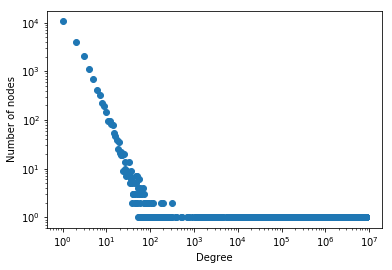

In [27]:
analysis.plot_degree_scatter(network_cleaned)

The plots yield that the underlying graph of the Numpy subcommunity is neither a scale-free network nor a random network. Its degree distribution follows a  super linear network.   

We can still calculate γ of the distribution to compare it to other networks


### Scale Free Networks

In scale free networks there exists a linear dependency between the logarithm of the probability and the logarithm of the degree:  
$log(p(k)) \sim -y  log(k) $

Gamma can then be calculated by fitting a linear regression between $log(p(k))$ and $log(k)$. The slope of the regression line is the gamma of the scale free network.

In [28]:
analysis.get_gamma_power_law(network_cleaned)

2.8496114614348307

In [29]:
analysis.get_in_gamma_power_law(network_direted_cleaned)

3.3057112796122894

In [30]:
analysis.get_out_gamma_power_law(network_direted_cleaned)

2.6989921522561655

For now we will keep these numbers in mind. We will come back to them later.

### Network evolution

In most cases the growth of a network is clearly correlated with time. Most models simply  regard the time until a new node joins the network as a time step. In real networks this time can widely differ and therefore we decided to plot over time to look at the changes in network in a certain timeframe rather than a certain magnitude of change. Nonetheless it is implied that more and more nodes join the network over the weeks.

In [31]:
networks = evol.split_network(network)

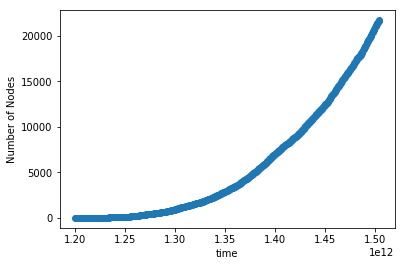

In [32]:
evol.plot_t_n(networks)

<img src="files/imgs/WWWYearNodes.png"/>

#### Number of Nodes over Time
In order to gain a better understanding of how these networks evolve over time we observed various network attributes over time to network models such as Barabási-Albert Model.
These two curves depict the number of nodes present in the network plotted over time. It’s clear that the growth of the network is accelerating in both cases.


C:\Users\M4X\Documents\Uni\EPFL\ntds\StackOverflowNetworkAnalysis\NetworkAnalysis.py:55: RuntimeWarning: Mean of empty slice.
  return np.asarray(list(network.degree(network.nodes()).values())).mean()
C:\Users\M4X\AppData\Local\conda\conda\envs\ntds\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


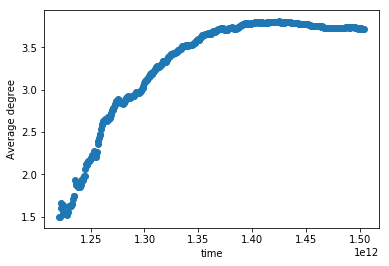

In [33]:
evol.plot_t_k_avg(networks)

#### ⟨ k⟩ over time
The average degree of the nodes within the network closely follows a logistic curve converging at an average degree value of about 3.6.

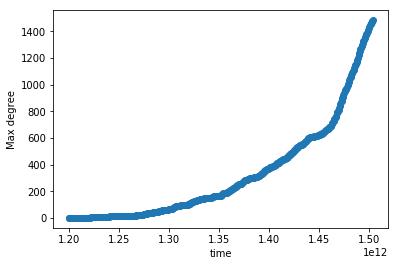

In [34]:
evol.plot_t_k_max(networks)

####  k<sub>max</sub> over Time
The growing number of nodes accelerates the rise in maximum degree .The acelleration or stronger than linear growth of the maximum degree suggests that new nodes show a tendency to connect to already highly connected nodes. This superlinear preferential attachment incates that we will see high values of α in the following plots. 

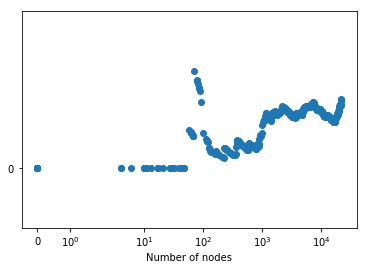

In [35]:
evol.plot_n_c(networks)

<img src="files/imgs/EvolClustering.png"/>

C:\Users\M4X\Documents\Uni\EPFL\ntds\StackOverflowNetworkAnalysis\NetworkAnalysis.py:55: RuntimeWarning: Mean of empty slice.
  return np.asarray(list(network.degree(network.nodes()).values())).mean()
C:\Users\M4X\AppData\Local\conda\conda\envs\ntds\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


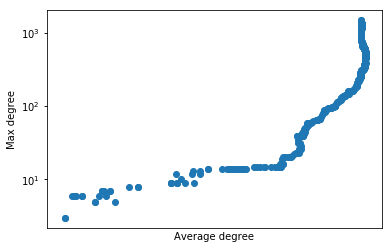

In [36]:
evol.plot_k_avg_k_max(networks)

<img src="files/imgs/EvolHubs.png"/>

#### k<sub>max</sub> over ⟨ k⟩
As indicated by the superlinear growth of maximum degree over time, we also see superlinear behvaior in the plot of maximum degree over average degree with values of α > 2.5.

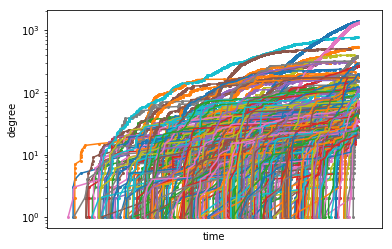

In [37]:
evol.DegreeDynamics(network_cleaned, 20)

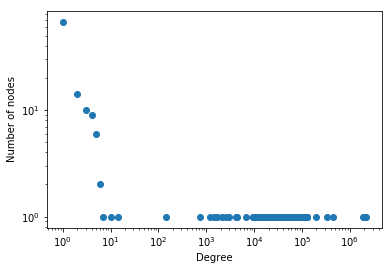

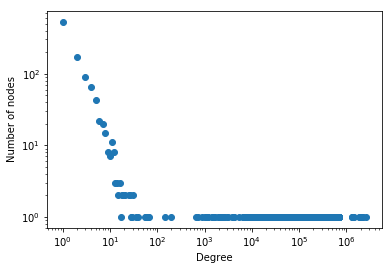

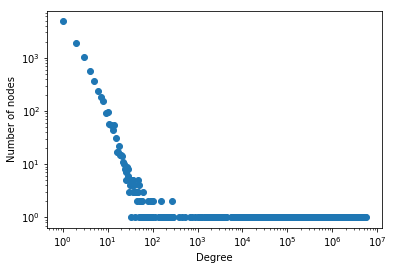

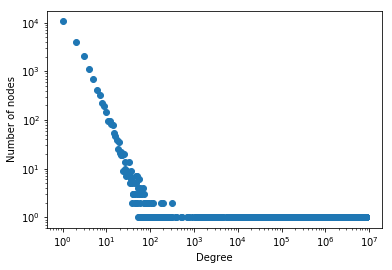

In [38]:
# n = 100
analysis.plot_degree_scatter(networks[1246320000000])

# n = 1000
analysis.plot_degree_scatter(networks[1302566400000])

# n = 10000
analysis.plot_degree_scatter(networks[1430179200000])

# all
analysis.plot_degree_scatter(network_cleaned)

<img src="files/imgs/EvolDegree.png"/>

#### Degree Dynamic and Degree Distribution in different Stages
In this section we compare the degree dynamics of the network nodes between the network implied from the StackOverflow data and network closely following the bevaiour of the Barabási-Albert Model. For this we selected degree distribution with similiar node counts **N**. While the Barabási-Albert network shows linearity in the degree distributions plots and the rise in the degree of the node plot lines, the and distributon plots of the StackOverflow community network show clear superlinear behaviour. The degree dynamic plot is prefiltered and only shows the plot lines for nodes that eventually reach a degree higher than 100. In these highly connected nodes we see a very quick development towards them becoming hubs in the network instagating the a topology that leans towards hub-and-spoke. In contrast to the Barabási-Albert network with a scale-free topology and power law dominated distributions.

### Comparison to other real world networks



<img src="files/imgs/OtherNetworks.png"/>

The Stack Overflow Numpy network behaves reagaring the ratio bewteen edges and nodes similary to the smaller networks as Power Grid and E. Coli Metabolism. It also behaves similiar to their gamma.  

But if one has a look at the parameters for the Python network, they are much closer to communication networks as the Science collaboration and Citation Network. This is most probably due to our tag selection. It is likely, that the complete Stack Overflow Networks behaves very similar to the Communication Networks with a gamma of up to 5.


### Classifier

In order to automatically detect super users we will train an unsupervised k-means clustering. This clustering is based on the attributes of nodes like:
* in degree
* out degree
* average question votes
* average answer votes

[Kmeans](https://github.com/epfml/ML_course/blob/master/lectures/08/lecture08b_kmeans_annotated.pdf) follows an iterative approach:  
In the first steps the data points are assigned the label of the nearest cluster.
$S_i^{(t)} = \big \{ x_p : \big \| x_p - \mu^{(t)}_i \big \|^2 \le \big \| x_p - \mu^{(t)}_j \big \|^2 \ \forall j, 1 \le j \le k \big\}$

After that a new center for each cluster is computed:  
$\mu^{(t+1)}_i = \frac{1}{|S^{(t)}_i|} \sum_{x_j \in S^{(t)}_i} x_j$  
  
This procedure is repeated until the location of clusters is not changing anymore.

Label statistics:
(array([0, 1, 2, 3, 4]), array([  858, 20719,     3,    65,    83], dtype=int64))


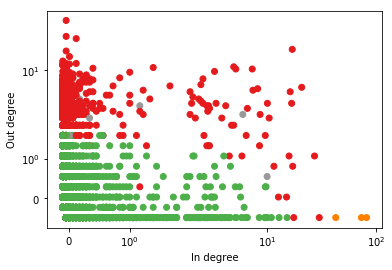

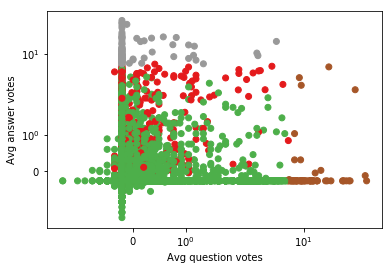

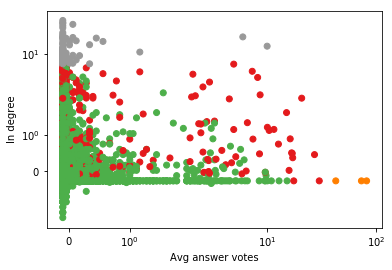

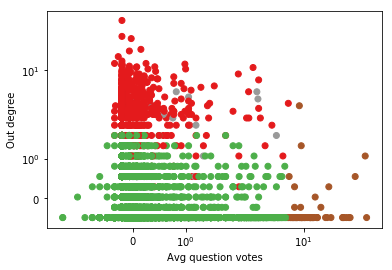

         a_votes    degree_in  degree_out    q_votes
label                                               
0       1.623069     9.987179   14.322844   8.377081
1       1.210277     1.342681    1.325160   1.266016
2       3.325829  1195.333333    0.000000   0.000000
3      97.258718     1.430769    0.707692   2.204945
4       2.379681     4.807229    8.132530  86.365739


In [39]:
classification.classify_users(network_directed)

We can see that there are very active users with label 0, who have answered  ten questions and asked fourteen questions in average.
The users from label 4 are also asking and answering several times, but they ask very good questions which score in average 85 votes.  
Users with label 1 are very inactive. They were only active once. These users are colored in green, located very close to the coordinates origin.  
The super users are further away from the origin.

### Group work models

In the beginning of this report we were aiming for an intuitive understanding of how collaboration networks like Stackoverflow work. Consequently, we will try to compare our extracted information with two common models for group work theory.  
First of all we have to define what exactly “work” is in Stackoverflow. As it is impossible to infer information about the actual project people are working on, we cannot measure the actual project work outcomes of individuals. However, we can define the knowledge transfer, i.e. answering of questions, as actual work.  
The Belbin Team Inventory describes different roles of people that is emerging from the formation of the group and was presented in Management Teams: Why They Succeed or Fail (1981). The extended Belbin Team inventory consists of the following types:  
**Plants** are creative generators of ideas.  

**Resource Investigators** provides enthusiasm at the start of a project and seizes contacts and opportunities.   

**Coordinators** have a talent for seeing the big picture and are therefore like to become the leader of the team.  

**Shaper** are driven by a lot of energy and the urge to perform. Therefore they usually make sure that all possibilities are considered and shake things up if necessary.   

**Monitor Evaluators** unemotional observers of the project and team. 
**Teamworkers** ensure that is the team running effectively and without friction.   

**Implementers** take suggestions and ideas and turns them into action.   

**Completers** are perfectionists and double-check the final outcome of the work.   

**Specialists** are experts in their own particular field and typically transfer this knowledge to others. Usually the stick to their domain of expertise.    

While it is hard to identify some of the types, e.g. the identification of a completer would require analysis of the whole answer text, it possible to find some similarities between our users
We calculated the different γ for incoming and outgoing degrees, i.e. how many hubs do we have for users based on asking questions and how many hubs do we have for answering questions.  

In [40]:
print("Gamma total: {}".format(analysis.get_gamma_power_law(network_cleaned)))
print("Gamma in: {}".format(analysis.get_in_gamma_power_law(network_direted_cleaned)))
print("Gamma out: {}".format(analysis.get_out_gamma_power_law(network_direted_cleaned)))


Gamma total: 2.8496114614348307
Gamma in: 3.3057112796122894
Gamma out: 2.6989921522561655


We can see that in fact there are more hubs for answering questions than for asking question. This can be interpreted as experts in their domain helping the average user out. This can be mapped to the role of the **Specialist** of the Belbin model. In fact we can see even in the classification that we have a distinct group of people who answer more than a thousand questions without even asking one themselves.  

Our graph is only built based on questions and answers. However, another graph could be created for votes and there we could obtain the role of the **Monitor Evaluator** as people who are hubs for voting and **Completers** for hubs of user who get good votes.  

So one insight we can get is that we have people who are specialists in their domains in our network are significantly more likely to answer questions than to ask them.   

The second model we can use is the Tuckman model describing the task related performance and the formation of the team over time.  

<img src="imgs/Teamwork.png">

In this case we actually have to understand that both dimension converge into one for online forums like Stackoverflow. Unlike Facebook there is now friendship system implemented. Thus, the only metric of relationship is the amount of edges between users. At the same time this the metric to measure our work outcome as define above. This assumption complies with the analysis of our edges over time.

### Further Notes

We tried to find clusters using spectral analysis. Due to the size of the networks that took too long. So unfortunately we were not able to obtain any insights.   
The same thing applies to the visualisation of the network.

## Conclusion

In this project we have analyzed the structure of the Stackoverflow community as an example for a commonly used online platform. As the entire network was too large for meaningful examination with our means we decided to focus on the subcommunity of Numpy instead. We showed that the size of subcommunities differs but the degree distribution plots show superlinear behavior and therefore the underlying graph structure demonstrated strong tendencies towards a hub and spike topology. The comparison provides evidence for our assumption that we can generalize from the Numpy subcommunity to other communities in Stackoverflow.


Last but not least, additonally one can note, that the network analysis comes to similar results compared to a simple user based analysis done for the Data Visualization Course: https://maxruenzepfl.github.io/StackoverflowAnalysis/indexReloaded.html

## References

The scatter plots for the data exploitation were taken from the Network Tour of Data Science Course.  

The teamwork graphic was retrieved from [here](http://the-happy-manager.com/articles/teamwork-theory/).  
The teamwork theory papers are the following:
* Management Teams: Why they succeed or fail Author: R. Meredith Belbin. Heinemann, 1981.
* Zoltan, Raluca. (2016). Work group development models - the evolution from simple group to effective team. Ecoforum. 5.
* https://www.researchgate.net/publication/299563074_Work_group_development_models_-_the_evolution_from_simple_group_to_effective_team
